# A Study of Crime in the state of New York

Study the nature of crimes in the New York State and New York City:

1. Is the crime rate higher in New York City compared to the rest of the state?
2. Is the rate of violent crimes higher in NYC compared to the rest of the state? 
3. Has there been an increase or decrease in the overall crime rate in NYC since 1990?
4. How well can we predict the overall crime rate in NYC with year, population and County as the variables?

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats.mstats import ttest_ind
from statsmodels.tsa.stattools import adfuller
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV


%matplotlib inline

In [110]:
data = pd.read_csv('https://data.ny.gov/api/views/34dd-6g2j/rows.csv?accessType=DOWNLOAD')

In [111]:
data.head()

,County,Year,Population,Index Count,Index Rate,Violent Count,Violent Rate,Property Count,Property Rate,Firearm Count,Firearm Rate
0,Albany,2016,308401.0,8764,2841.8,1102,357.3,7662,2484.4,126.0,40.9
1,Albany,2015,308613.0,8635,2798.0,1041,337.3,7594,2460.7,114.0,36.9
2,Albany,2014,308166.0,9181,2979.2,1003,325.5,8178,2653.8,147.0,47.7
3,Albany,2013,306300.0,9457,3087.5,1006,328.4,8451,2759.1,150.0,49.0
4,Albany,2012,305204.0,9975,3268.3,1012,331.6,8963,2936.7,137.0,44.9


In [112]:
pop = data.groupby(['Year']).sum()['Population']

Text(0.5,1,'Population Growth in the State of NY')

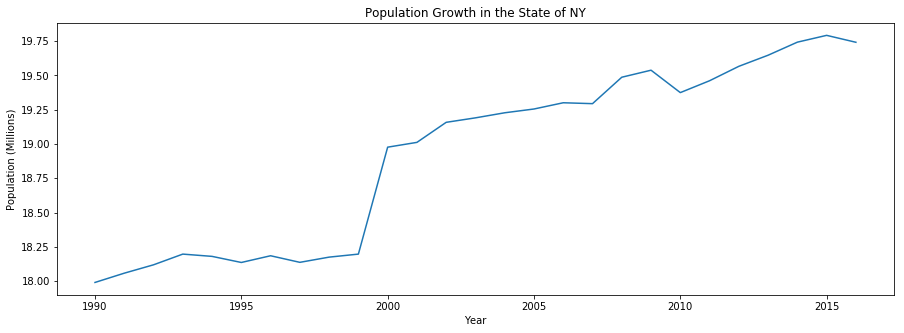

In [187]:
plt.figure(figsize=(15,5))
plt.plot(pop.index, pop/1000000)
plt.xlabel('Year')
plt.ylabel('Population (Millions)')
#plt.text(.5, .05, 'Population Growth in the State of NY', ha='center')
plt.title('Population Growth in the State of NY')


Fig1: Population of the state of NY plotted against year from 1990 to 2016

In [114]:
data.shape

(1674, 11)

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 11 columns):
County            1674 non-null object
Year              1674 non-null int64
Population        1674 non-null float64
Index Count       1674 non-null int64
Index Rate        1674 non-null float64
Violent Count     1674 non-null int64
Violent Rate      1674 non-null float64
Property Count    1674 non-null int64
Property Rate     1674 non-null float64
Firearm Count     1599 non-null float64
Firearm Rate      1599 non-null float64
dtypes: float64(6), int64(4), object(1)
memory usage: 143.9+ KB


*** There is some data missing in the firearm count/firearm rate. These columns will be dropped because my focus is on the crime rate only *** 

*** How many counties are there?***

In [116]:
data.groupby(['County']).sum().index

Index(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia', 'Cortland',
       'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin', 'Fulton',
       'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Kings',
       'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery', 'Nassau',
       'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontario', 'Orange',
       'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens', 'Rensselaer',
       'Richmond', 'Rockland', 'Saratoga', 'Schenectady', 'Schoharie',
       'Schuyler', 'Seneca', 'St Lawrence', 'St. Lawrence', 'Steuben',
       'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype='object', name='County')

In [117]:
len(data.groupby(['County']).sum().index)

63

*** There are 63 Counties. Among this the counties in NYC are: 'New York', 'Kings', 'Bronx', 'Queens', 'Richmond' ***

In [118]:
# Let us create a list of counties in NYC and a list of counties in the rest of the state
nyc = ['New York', 'Kings', 'Bronx', 'Queens', 'Richmond' ]

rest = [i for i in data.groupby(['County']).sum().index if i not in nyc]

In [119]:
data1 = data.copy()

data1['place'] = data1['County'].apply(lambda i: 'nyc' if i in nyc else 'rest')

In [120]:
data2 = data1.drop(['County', 'Index Rate', 'Violent Rate', 'Property Rate', 'Firearm Count' ,'Firearm Rate'], axis=1)

In [121]:
data_rural = data2[data2['place'] == 'rest'].drop(['place'], axis =1)
data_urban = data2[data2['place'] == 'nyc'].drop(['place'], axis =1)

data_rural.shape, data_urban.shape

((1539, 5), (135, 5))

In [122]:
data_rural.head()

,Year,Population,Index Count,Violent Count,Property Count
0,2016,308401.0,8764,1102,7662
1,2015,308613.0,8635,1041,7594
2,2014,308166.0,9181,1003,8178
3,2013,306300.0,9457,1006,8451
4,2012,305204.0,9975,1012,8963


In [123]:
yearly_rural_data = data_rural.groupby(['Year']).sum()
yearly_urban_data = data_urban.groupby(['Year']).sum()

# 1. Comparing the overall crime rate in NYC with Rest of the State

*** Hypothesis : Crime rate in NYC is higher than rest of the state ***

*** H0: There is no difference in the index crime rate per 1000 people between NYC and rest of the state. Significance 0.05 ***

*** Ha: The index crime rate per 1000 people for NYC is greater than rest of the state. Significance 0.05 ***

***We will perform one tailed t-test to compare the 2 variables. We assume that the 2 variables are independant ***

In [124]:
yearly_rural_data['index_per_thousand'] = (yearly_rural_data['Index Count']/yearly_rural_data['Population'])*1000
yearly_urban_data['index_per_thousand'] = (yearly_urban_data['Index Count']/yearly_urban_data['Population'])*1000

In [125]:
ttest_ind(yearly_rural_data['index_per_thousand'], yearly_urban_data['index_per_thousand'], equal_var= False)

Ttest_indResult(statistic=-2.7406030551752747, pvalue=0.010209896841721832)

***Two sided p-value = 0.0102 (rounded) ***


***One sided P-value = 0.0102/2 = 0.0050 ***

***P-value is less than 0.05 so we reject the Null hypothesis. The crime rate per 1000 people in NYC is greater than the rest of the state. This is along expected lines.***

# 2. Comparing the Violent Crime rate of NYC with the rest of the state

*** Hypothesis : Violent Crime rate in NYC is higher than rest of the state ***

*** H0: There is no difference in the Violent crime rate per 1000 people between NYC and rest of the state. Significance 0.05 ***

*** Ha: The Violent crime rate per 1000 people for NYC is greater than rest of the state. Significance 0.05 ***

***We will perform one tailed t-test to compare the 2 variables. We assume that the 2 variables are independant ***

In [128]:
yearly_rural_data['violent_per_thousand'] = (yearly_rural_data['Violent Count']/yearly_rural_data['Population'])*1000
yearly_urban_data['violent_per_thousand'] = (yearly_urban_data['Violent Count']/yearly_urban_data['Population'])*1000

In [129]:
ttest_ind(yearly_rural_data['violent_per_thousand'], yearly_urban_data['violent_per_thousand'], equal_var= False)

Ttest_indResult(statistic=-6.6561400352517976, pvalue=4.3266626834383776e-07)

***Two sided p-value = 4.32e-07 (rounded) ***


***One sided P-value = 2.16e-07 ***

***P-value is less than 0.05 so we reject the Null hypothesis. The violent crime rate per 1000 people in NYC is greater than the rest of the state. This is along expected lines.***

# 3.Has there been an increase or decrease in the overall crime rate in NYC since 1990?

In [131]:
yearly_urban_data.head()

,Population,Index Count,Violent Count,Property Count,index_per_thousand,violent_per_thousand
Year,,,,,,
1990,7322564.0,711556,174689,536867,97.173067,23.856261
1991,7350023.0,680521,170486,510035,92.587601,23.195302
1992,7375097.0,627237,159655,467582,85.047966,21.647851
1993,7347257.0,600403,153548,446855,81.717980,20.898684
1994,7336224.0,530827,136571,394256,72.356978,18.615980


Consider the overall crime rate

In [135]:
yearly_index_urban = yearly_urban_data['index_per_thousand']

*** First we will do a visual inspection with a plot ***

Text(0,0.5,'Total number of crimes per 1000 people')

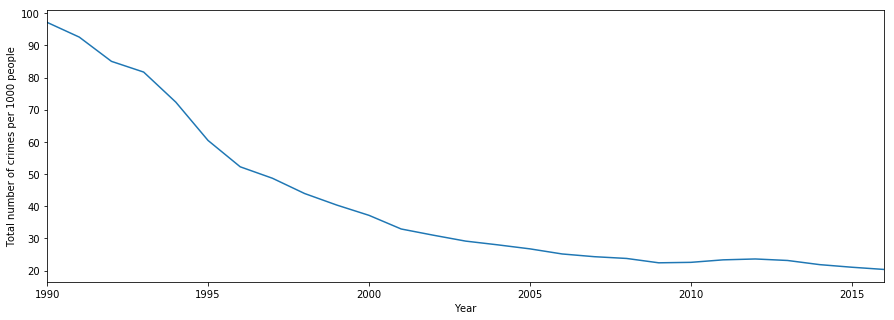

In [188]:
plt.figure(figsize=(15,5))
yearly_index_urban.plot()
plt.xlabel('Year')
plt.ylabel('Total number of crimes per 1000 people')

Fig2: A plot showing the total number of crimes per 1000 people in the city of New York plotted against year starting from 1990 to 2016

*** From the graph it clearly looks like the crime rate has decreased ***

### Use Summary Statistics

In [140]:
# Partitioning the data
yearly_index_urban_first = yearly_index_urban.iloc[:5]

yearly_index_urban_last = yearly_index_urban.iloc[-5:]

In [143]:
yearly_index_urban_first.describe()

count     5.000000
mean     85.776718
std       9.661247
min      72.356978
25%      81.717980
50%      85.047966
75%      92.587601
max      97.173067
Name: index_per_thousand, dtype: float64

In [144]:
yearly_index_urban_last.describe()

count     5.000000
mean     22.003844
std       1.374560
min      20.357615
25%      21.044430
50%      21.854184
75%      23.148176
max      23.614815
Name: index_per_thousand, dtype: float64

In [162]:
ratio = yearly_index_urban_first.mean()/yearly_index_urban_last.mean()

print('Ratio is:', ratio)

Ratio is: 3.89826060904


*** From the summary statistics it is clear that the mean number of crimes in NYC has decreased from 85 to 22 per thousand people ***

In [157]:
result = adfuller(yearly_urban_data['index_per_thousand'])

In [158]:
result

(-5.6028238370206882,
 1.2534776230808054e-06,
 4,
 22,
 {'1%': -3.7697326258452288,
  '10%': -2.6425009917355373,
  '5%': -3.0054255371900829},
 32.264906769414324)

In [159]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.602824
p-value: 0.000001
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643


*** ADF result suggests that the series is stationary. But ADF is not a very strong test and the summary statistics suggest strongly that the series is decreasing. So we conclude that the crime rate per 1000 people in NYC is decreasing ***

# Visualization of crime rates from 1990-2016 in NYC and rest of the NY state 

Text(0,0.5,'Number of incidents')

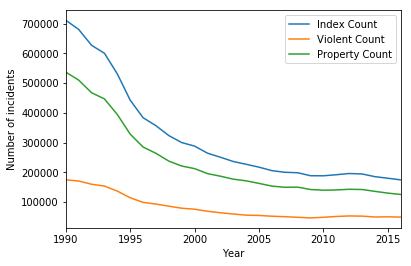

In [191]:
data_urban.groupby(['Year']).sum().drop(['Population'], axis =1).plot()
plt.ylabel('Number of incidents')

Fig3: Visualization of various crimes in the City of NYC 

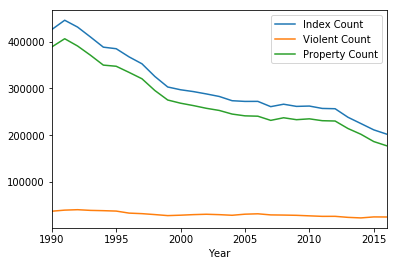

In [127]:
data_rural.groupby(['Year']).sum().drop(['Population'], axis =1).plot()

Fig4: Visualization of various crimes in the rest of the NY state

# 4.How well can we predict the overall crime rate in NYC with this dataset?

In [163]:
data1.head()

,County,Year,Population,Index Count,Index Rate,Violent Count,Violent Rate,Property Count,Property Rate,Firearm Count,Firearm Rate,place
0,Albany,2016,308401.0,8764,2841.8,1102,357.3,7662,2484.4,126.0,40.9,rest
1,Albany,2015,308613.0,8635,2798.0,1041,337.3,7594,2460.7,114.0,36.9,rest
2,Albany,2014,308166.0,9181,2979.2,1003,325.5,8178,2653.8,147.0,47.7,rest
3,Albany,2013,306300.0,9457,3087.5,1006,328.4,8451,2759.1,150.0,49.0,rest
4,Albany,2012,305204.0,9975,3268.3,1012,331.6,8963,2936.7,137.0,44.9,rest


In [178]:
y = data1['Index Rate']

X = data1[['Year', 'Population', 'County']]

In [181]:
X = pd.get_dummies(X)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1121, 65), (553, 65), (1121,), (553,))

In [183]:
alpha = [10**i for i in range(-5,5)]
ridge = RidgeCV(alphas=alpha, cv=5).fit(X_train,y_train)
lasso = LassoCV(alphas=alpha, cv=5).fit(X_train,y_train)
print('the train R-square using Ridge is : ', ridge.score(X_train,y_train))
print('the test R-square using Ridge is : ', ridge.score(X_test,y_test))

print('the train R-square using Lasso is : ', lasso.score(X_train,y_train))
print('the test R-square using Lasso is : ', lasso.score(X_test,y_test))



/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


the train R-square using Ridge is :  0.801200958394
the test R-square using Ridge is :  0.787497897615
the train R-square using Lasso is :  0.801117369991
the test R-square using Lasso is :  0.786287046662


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


The test R-square obtained here using only the year, county and population as parameters is 0.787 using Ridge regression and cross validation. With this limited dataset we are able to explain 78.7% of the variance
